In [1]:
import os

In [2]:
import pickle

In [3]:
random_seed = 42

In [4]:
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)

import pandas as pd
pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 512)
pd.set_option('display.max_colwidth', -1)

In [5]:
import csv

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset

In [8]:
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
from tqdm import tqdm

In [10]:
from sklearn.metrics import classification_report

In [11]:
from scipy import stats

In [12]:
output_collections_list = []
for idx in range(0, 9000+1, 1000):
    with open("saved/score_42/{}.pkl".format(idx), "rb") as handle:
        output_collections = pickle.load(handle)    
        print(output_collections[0]['prob'])
        print(len(output_collections))
        
    if idx==0:
        output_collections_list = output_collections
    else:
        output_collections_list += output_collections
len(output_collections_list)        

[1.3119584e-06 1.6234579e-06 4.4109314e-05 1.3470741e-04 1.0314246e-05
 9.6942771e-05 9.9966776e-01 1.5807591e-06 8.2067181e-06 3.3498505e-05]
1000
[0.00296345 0.01543871 0.20667087 0.08410855 0.10940073 0.36600584
 0.00233175 0.1709157  0.00100259 0.04116183]
1000
[0.03537454 0.00897479 0.36102456 0.05171341 0.02095333 0.00722984
 0.2574968  0.22482738 0.0155394  0.01686599]
1000
[1.3831571e-03 2.7952669e-03 6.5201825e-06 6.4640801e-05 2.8206514e-06
 2.7173216e-06 9.7886441e-06 4.5515499e-05 8.5003092e-04 9.9483949e-01]
1000
[9.9986207e-01 5.4976731e-06 9.7504271e-05 1.2431217e-06 3.3806380e-06
 1.3077515e-07 6.2407008e-07 2.6388716e-06 1.5650423e-05 1.1368608e-05]
1000
[6.3092459e-04 8.7274838e-04 2.8286800e-03 8.4994286e-01 4.3542974e-02
 8.7668546e-02 8.7624583e-03 4.2916210e-03 4.5917073e-04 9.9998806e-04]
1000
[2.1776385e-04 5.0199546e-05 9.7584164e-01 3.6946794e-03 8.3056157e-03
 2.2447994e-03 8.2336401e-04 8.6970748e-03 8.2834544e-05 4.2095326e-05]
1000
[3.6450803e-02 1.4732902

10000

In [13]:
data = []
for i in output_collections_list:
    data.append([i['index'], i['prob'], i['label'], i['prediction'],
                 i['influence_prime'], 
                 i['influence'], 
                 i['diff'], 
                 i['theta'], i['attributions'],
                ])

df_0 = pd.DataFrame(data, columns=['cifar_index', 'prob', 'label', 'prediction',
                                   'influence_prime', 'influence', 'diff', 
                                   'theta', 'attributions'
                                  ])



df_0['theta'] = -df_0['theta']
df_0['attributions'] = -df_0['attributions']

In [14]:
drop_index = df_0[df_0['influence']<=0].index
len(drop_index)

156

In [15]:
df_0.loc[drop_index, 'influence'] = 0.0

In [16]:
df_0['rank'] = df_0['influence'].rank(method='first', ascending=False)

In [17]:
df_0['rank'].head()

0    9641.0
1    6919.0
2    3750.0
3    862.0 
4    6590.0
Name: rank, dtype: float64

In [18]:
mem_list = []
for i in range(0, 100, 10):
    k = int(len(df_0)*i/100)
    print(k)
    mem_list.append(df_0[df_0['rank']==k+1]['influence'].values[0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [19]:
mem_list

[7.882788181304932,
 2.6482622623443604,
 1.2516711950302124,
 0.43612605333328247,
 0.13282029330730438,
 0.036054544150829315,
 0.00951551366597414,
 0.002116149291396141,
 0.000348960718838498,
 3.3709471608744934e-05]

In [20]:
def read_report(output_path, order, percentage, seed, epoch, split):
    df = pd.read_csv(os.path.join(output_path, order, percentage, seed, "report/{}_{}.csv".format(epoch-1, split)))
    return df

In [21]:
original = []
for seed in [0, 1, 2, 3, 42]:
    df = read_report('saved', 'random', str(0), str(seed), 10, 'test')
    original.append(df.loc[10][1])
original

[0.8816, 0.8809999999999999, 0.8822, 0.882, 0.8821]

In [22]:
percentage_list = [
    10, 
    20, 
    30, 
    40, 
    50
]

In [23]:
result_dict = {}

for order in [
    'random_0', 
    'random_2', 
    'random', 
    'mem'
]:
    for percentage in percentage_list:
        result_dict[order+'_'+str(percentage)] = []
        for seed in [0, 1, 2, 3, 42]:
            df = read_report('saved', order, str(percentage), str(seed), 10, 'test')
            result_dict[order+'_'+str(percentage)].append(df.loc[10][1])

In [24]:
df

,Unnamed: 0,f1-score,precision,recall,support
0,0,0.872583,0.865290,0.8800,1000.0000
1,1,0.913655,0.917339,0.9100,1000.0000
2,2,0.820272,0.858862,0.7850,1000.0000
3,3,0.718256,0.789222,0.6590,1000.0000
4,4,0.817773,0.816550,0.8190,1000.0000
5,5,0.810311,0.788826,0.8330,1000.0000
6,6,0.851541,0.798599,0.9120,1000.0000
7,7,0.854251,0.864754,0.8440,1000.0000
8,8,0.914480,0.889414,0.9410,1000.0000
9,9,0.899851,0.896723,0.9030,1000.0000


In [25]:
result_dict

{'random_0_10': [0.8797, 0.8795, 0.8796, 0.8807, 0.8803],
 'random_0_20': [0.8785, 0.8784, 0.8762, 0.8767, 0.8788],
 'random_0_30': [0.877, 0.8771, 0.8758, 0.8769, 0.8752],
 'random_0_40': [0.8717, 0.8746, 0.8713, 0.8729, 0.873],
 'random_0_50': [0.8701, 0.87, 0.8716, 0.8701, 0.8692],
 'random_2_10': [0.8809999999999999, 0.8804, 0.8806, 0.8802, 0.8795],
 'random_2_20': [0.8772, 0.8784, 0.8771, 0.8768, 0.8789],
 'random_2_30': [0.8777, 0.8761, 0.8761, 0.8761, 0.8763],
 'random_2_40': [0.8745, 0.8744, 0.8748, 0.8746, 0.8745],
 'random_2_50': [0.8719, 0.8742, 0.8714, 0.8715, 0.8729],
 'random_10': [0.8772, 0.8785, 0.8767, 0.8775, 0.8764],
 'random_20': [0.8768, 0.8769, 0.8771, 0.8761, 0.8764],
 'random_30': [0.8758, 0.875, 0.8745, 0.8744, 0.8762],
 'random_40': [0.8759999999999999, 0.8739, 0.8752, 0.8739, 0.875],
 'random_50': [0.871, 0.8708, 0.8723, 0.8712, 0.871],
 'mem_10': [0.8714, 0.8724, 0.8713, 0.8712, 0.8717],
 'mem_20': [0.8653, 0.866, 0.8654, 0.8666, 0.8656],
 'mem_30': [0.8585,

In [26]:
random_mean_ = []
random_std_ = []

random_mean_.append(np.mean(original)*100)
random_std_.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['random_'+str(percentage)] + result_dict['random_0_'+str(percentage)] + result_dict['random_2_'+str(percentage)]
    random_mean_.append(np.mean(result)*100)
    random_std_.append(np.std(result)*100)

In [27]:
random_mean_

[88.178,
 87.91866666666667,
 87.73533333333333,
 87.60133333333332,
 87.40199999999999,
 87.128]

In [28]:
random_std_

[0.04400000000000303,
 0.1486771296766552,
 0.09379883913046126,
 0.09164181481301142,
 0.12453647390757928,
 0.12078631269035979]

In [29]:
mem_mean = []
mem_std = []

mem_mean.append(np.mean(original)*100)
mem_std.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['mem_'+str(percentage)]
    mem_mean.append(np.mean(result)*100)
    mem_std.append(np.std(result)*100)

In [30]:
mem_mean

[88.178, 87.16, 86.578, 85.916, 85.60399999999998, 84.92599999999999]

In [31]:
mem_std

[0.04400000000000303,
 0.04335896677735743,
 0.047497368348154295,
 0.05425863986500141,
 0.028705400188815816,
 0.05817215828899458]

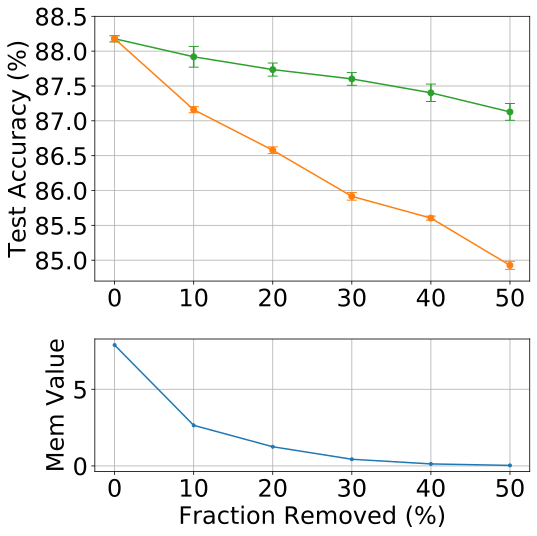

In [32]:
matplotlib.rcParams.update({'font.size': 24})

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

x = range(0, 60, 10)

ax0.errorbar(x, random_mean_, 
            yerr=random_std_, 
            linestyle='-', 
            fmt='o', label='random', color='tab:green', capsize=5)
ax0.errorbar(x, mem_mean, 
            yerr=mem_std, 
            linestyle='-', fmt='o', label='memorized', color='tab:orange', capsize=5)

ax0.set_ylabel('Test Accuracy (%)')
ax0.set_xticks(x)

ax0.set_yticks(np.arange(np.round(min(random_mean_+mem_mean), 0), np.round(max(random_mean_+mem_mean), 0)+1.0, 0.5))

ax0.grid(True)


ax1.set_xlabel('Fraction Removed (%)')
ax1.set_ylabel('Mem Value')
ax1.set_xticks(x)
ax1.set_yticks(np.arange(0, df_0['influence'].max()+5, 5))



ax1.plot(x, mem_list[0: len(x)], color='tab:blue', marker='.')
ax1.grid(True)

fig.tight_layout()
# plt.show()

filename = "saved/vis/Marginal_CIFAR.pdf"
os.makedirs(os.path.dirname(filename), exist_ok=True)  

plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  